In [13]:
import torchvision

# Fine-Tuning Pretrained Networks for Image Classification

In [1]:
# https://docs.fast.ai/tutorial.vision.html

In [1]:
from fastai.vision.all import *

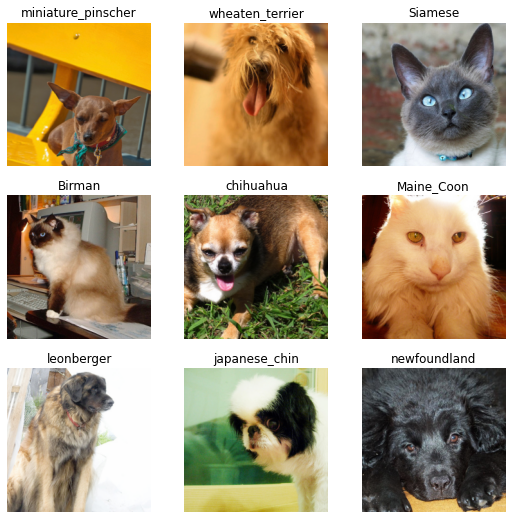

In [2]:
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")
pat = r'^(.*)_\d+.jpg' # What is this magic?
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(460),
                                    batch_tfms=aug_transforms(size=224))
dls.show_batch()

In [3]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0014454397605732083)

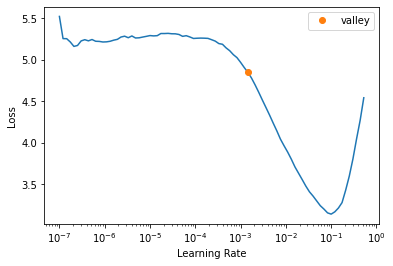

In [4]:
learn.lr_find()

In [7]:
learn.fine_tune(2, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.274803,0.354678,0.112991,00:34


epoch,train_loss,valid_loss,error_rate,time
0,0.519178,0.370450,0.104195,00:43
1,0.312444,0.207476,0.062923,00:43


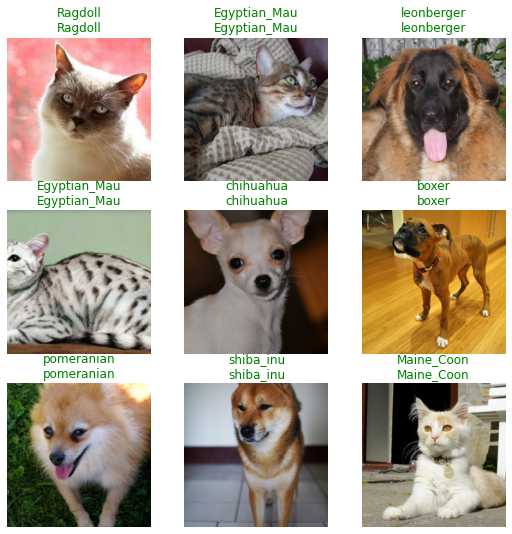

In [8]:
learn.show_results()

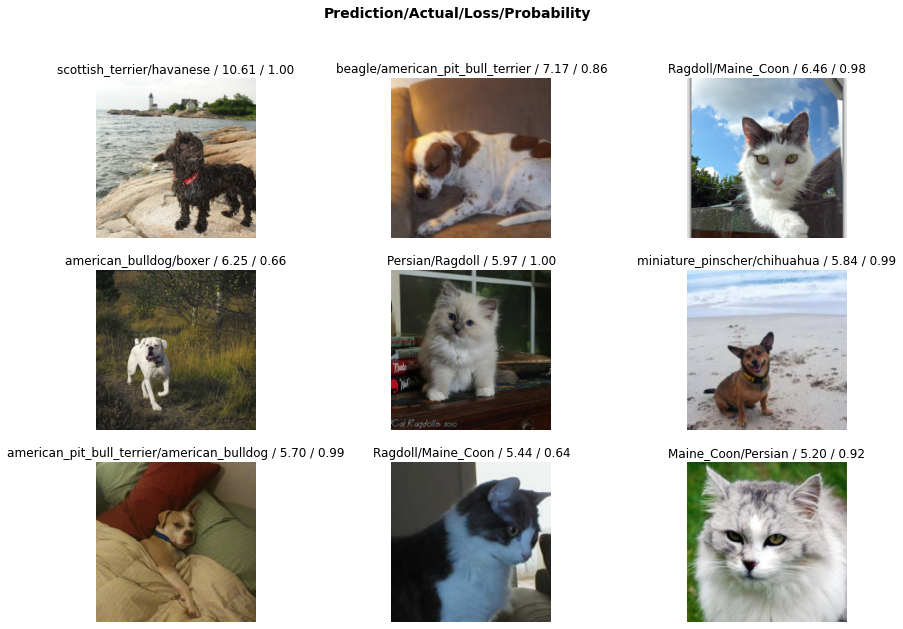

In [9]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

In [21]:
# ??learn.fine_tune

In [20]:
# ??learn.fit_one_cycle

## Replicating (some of) this in PyTorch

In [5]:
import gc
del learn
gc.collect()
torch.cuda.empty_cache()

In [6]:
xb, yb = dls.one_batch()
xb.shape, yb

(torch.Size([64, 3, 224, 224]),
 TensorCategory([34, 17,  7, 33,  6, 33, 23, 36,  5,  2,  4, 29, 24, 13,  1,  1,
                 11, 13,  2,  5, 29, 18, 14, 16, 16,  5, 35, 20, 35,  9, 32,  4,
                 34,  2,  9,  1, 15, 36, 20, 29, 12, 26, 29,  2, 32, 22, 18,  1,
                 32, 12, 26,  6,  5, 10, 12, 35, 36, 15, 33, 22,  4,  0, 10, 25],
                device='cuda:0'))

In [7]:
len(dls.vocab), dls.vocab

(37,
 ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier'])

In [29]:
model = resnet34(weights=torchvision.models.ResNet34_Weights.DEFAULT)
model.fc = nn.Linear(512, 37)
model.to(xb.device)
with torch.no_grad():
    preds = model(xb)
preds.shape

torch.Size([64, 37])

In [30]:
# model

In [31]:
loss_fn = CrossEntropyLossFlat()
loss_fn(preds, yb)

TensorBase(3.9893, device='cuda:0')

In [32]:
[p.shape for p in model.fc.parameters()]

[torch.Size([37, 512]), torch.Size([37])]

In [33]:
losses = []

# Freeze all layers (requires_grad=False)
for p in model.parameters():
    p.requires_grad = False

# Unfreeze final layer
for p in model.fc.parameters():
    p.requires_grad= True

# Optimizer on just these unfrozen parameters
opt = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

# Train for one epoch
for xb, yb in dls.train:
    preds = model(xb)
    loss = loss_fn(preds)
    losses.append(loss.item())
    loss.backward()
    opt.step()
    opt.zero_grad()

Plotting the losses:

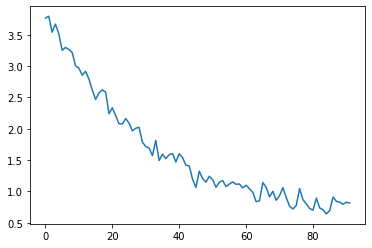

In [33]:
plt.plot(losses)

Second stage:

In [34]:
# Unfreeze the rest of the model parameters
for p in model.parameters():
    p.requires_grad = True

# New optimizer and train a bit more at a lower learning rate
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
for xb, yb in dls.train:
    preds = model(xb)
    loss = loss_fn(preds, yb)
    losses.append(loss.item())
    loss.backward()
    opt.step()
    opt.zero_grad()

Plotting the losses, showing this second epoch in yellow:

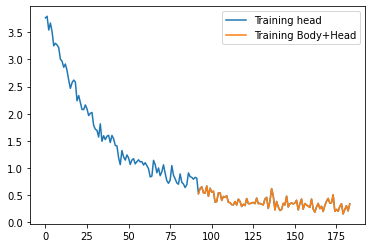

In [56]:
#|hide    
plt.plot(losses, label = 'Training head')
l = len(dls.train)
plt.plot(range(l, l*2), losses[-l:], label='Training Body+Head')
plt.legend();

Calculating Accuracy:

In [61]:
#|hide
right = 0
total = 0
for xb, yb in dls.valid:
    with torch.no_grad():
        preds = model(xb)
    pred_labels = preds.argmax(dim=1)
    right += (yb.cpu().numpy() == pred_labels.cpu().numpy()).sum() # Quick and dirty check count of how many preds in pred_labels match the true labels in yb
    total += yb.shape[0] # The total number of examples in this batch

print(f'Accuracy on validation set: {100*right/total:.2f}%')

Accuracy on validation set: 92.15%


What are the tricks here?
- Data Augmentation
- Learning Rate Finder
- Learning Rate Schedule (ref one_cycle paper)
- Nice metrics, tracking, etc.


As you start doing these experiments, tracking is useful

TODO link intro to experiment tracking